# Data Analysis Project: Exploring Chicago Transit Authority Bus Ridership

In this project, I will be working with data on ridership in the Chicago Transit Authority (CTA) system between January 2001 and December 2017. 

I will be working with the datascience module introduced in Data 8 as well as with the numpy library. While the datascience module is quite similar to pandas, I chose to work with it rather than pandas because it has been used in Data 8 and its connector courses.

<img src="http://chicagorailfan.com/map1952n.gif"/>

In [9]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## The Dataset

The dataset that I am working with can be found at the link below:

https://catalog.data.gov/dataset/cta-ridership-bus-routes-monthly-day-type-averages-totals-7a070

I've also printed it out below with relabeled columns which are easier to work with

In [10]:
cta = Table.read_table('CTA.csv').relabel(0, 'Route').relabel(1, 'Name').relabel(2, 'Month').relabel(3, 'Weekday Avg').relabel(4, 'Saturday Avg').relabel(5, 'Sunday Avg').relabel(6, 'Total')
cta

Route,Name,Month,Weekday Avg,Saturday Avg,Sunday Avg,Total
1,Indiana/Hyde Park,01/01/2001,6982.6,0,0,153617
2,Hyde Park Express,01/01/2001,1000,0,0,22001
3,King Drive,01/01/2001,21406.5,13210.7,8725.3,567413
4,Cottage Grove,01/01/2001,22432.2,17994,10662.2,618796
6,Jackson Park Express,01/01/2001,18443,13088.2,7165.6,493926
7,Harrison,01/01/2001,5504.4,0,0,121097
8,Halsted,01/01/2001,19582.2,12420,8280.8,521892
8A,South Halsted,01/01/2001,3196.5,3006.6,1336.2,89030
9,Ashland,01/01/2001,29265.4,22621.7,15336.1,811006
10,Museum of S & I,01/01/2001,0,562.6,372.9,4115


## The Questions

With this project I aim to use the dataset to explore:

1. **Growth Rates:** On average, does the number of riders per bus line per year tend to increase or decrease? What is the yearly growth rate for each station? What is the average yearly growth rate? Which routes have the highest and lowest yearly growth rates and why might this be the case based on further research into local trends?

2. **Ventra:** In August 2013, the CTA launched its partnership with Ventra, an electronic fare payment system. Ventra was meant to replace all other existing methods of payment by July 2014. What kind of impact, if any, has launching Ventra had on CTA bus ridership? In particular, is there a statistically significant difference in ridership before Ventra’s launch, during the transition period (8/13 to 7/14), and after it became the sole payment system for the CTA?

3. **The University of Chicago:** Is there a statistically significant difference in average ridership for routes that lead to the University of Chicago (routes 170-173) during the summer versus during the school year?

## Growth

**The Question:** What is the average monthly growth rate for each bus line in the data set? Which routes have the highest and lowest average monthly growth rates?

**Statistical Methods**: in this part of the project I ask several relatively easy to answer questions. Yet, none of these questions really requires any knowledge of statistics besides knowledge of how to calculate an average.


**Setting up the Data:** Some lines in the dataset have data available for only one month while others have data available for all 204 months between 01/2001 and 12/2017. In other words, the panel data is unbalanced. Even though it doesn't really matter as much for this question since it's not an applied statistics question, it may be a good idea to balance the panel data anyway because it will come in handy for the other questions. The different weekday, Saturday, and Sunday/holiday averages are not quite useful to this inquiry so I drop those columns.

The table below contains only those lines for which data is available for all 204 months. It's a bit shorter but still contains a substantial amount of data.

To balance the data I will do the following:
1. First I create an array called `all_months` which contains the names of the routes for which data is available for all 204 months. In order to do so I group `cta` by the 'Name' column and use the `where` method to select only those entries in the resulting table that have a count equal to 204. The 'Name' column of this new table is `all_months`
2. Then I create a table called `balanced_table` which is `cta` but with only the entries wherein the 'Name' column corresponds to an entry in `all_months`.
3. Finally, I drop the irrelevant columns from this table and create a new table called `balanced_table`.

In [11]:
all_months = cta.group('Name').where('count', are.equal_to(204)).column('Name')
balanced_table = cta.where('Name', are.contained_in(all_months)).select(0,1,2,6)
balanced_table

Route,Name,Month,Total
2,Hyde Park Express,01/01/2001,22001
3,King Drive,01/01/2001,567413
4,Cottage Grove,01/01/2001,618796
6,Jackson Park Express,01/01/2001,493926
7,Harrison,01/01/2001,121097
8,Halsted,01/01/2001,521892
8A,South Halsted,01/01/2001,89030
9,Ashland,01/01/2001,811006
12,Roosevelt,01/01/2001,288055
18,16th/18th,01/01/2001,49130


Using the group and column methods, I create separate arrays from some of the columns of the table because they will be useful later. Here is what they are:

1. `months`: This is an array containing each of the 204 months in the dataset from '01/01/2001' to '12/01/2017'
2. `year_numbers`: This is an array containing the years in the dataset from 2001 to 2017. I use this to make a graph later.
3. `routes`: This array contains the number of each route.
4. `names`: This array contains the name of each route.

In [12]:
months = balanced_table.group('Month').column('Month')
year_numbers = np.arange(2001,2017)
routes = balanced_table.group('Route').column('Route')
names = balanced_table.group('Route', max).relabeled(1,'Name').column('Name')

We also use list comprehensions to create lists that will be helpful later. Here is what they are:

1. `growth`: a list containing every item in `months` that corresponds to January.
2. `january`: a list containing every item in `growth` besides the one which corresponds to January 2017.

In [13]:
growth = [month for month in months if '01/01' in month]
january = [month for month in growth if '01/01/2017' not in month]

And then using the where method with the `are.contained_in` predicate, I create smaller tables from `balanced` table which contain only data for months included in these lists.

In [14]:
growth_table = balanced_table.where('Month', are.contained_in(growth))
january_table = balanced_table.where('Month', are.contained_in(january))

Below, I define a function, `growth`, which takes in a route number as an argument and returns the average monthly growth rate for that route based on the yearly growth rate. The function does the following:

1. Uses the 'Total' column of `january_table` for the chosen route as the initial level
2. Uses the `np.diff` function with the 'Total' column of `growth_table` for the chosen route to find the change in ridership
3. Calculates the growth rate by dividing change by initial
4. Using the growth rate formula introduced in Data 8, calculated the monthly growth rate.
5. Returns the average monthly growth rate as a percentage

In [15]:
def growth(route):
    initial = january_table.where('Route', route).column('Total')
    change = np.diff(growth_table.where('Route', route).column('Total'))
    growth = change / initial
    monthly_growth = (np.mean(((growth + 1)**(1/12)) - 1))
    return round(100*monthly_growth,3)
growth('2')

0.574

Using a for loop and the growth function defined above, I calculate the average monthly ridership growth rate for each route in `balanced_table` and create a new table containing the route number, the route name, and the calculated growth rates.

In [16]:
growth_rates_array = make_array()
for i in routes:
    growth_a = growth(i)
    growth_rates_array = np.append(growth_rates_array, growth_a)
growth_rates_array
growth_rates_table = Table().with_columns('Route', routes, 'Name', names, 'Avg Monthly Growth Rate Percentage', growth_rates_array)

The table containing all of the average monthly growth rates as percentages is printed below

In [17]:
growth_rates_table

Route,Name,Avg Monthly Growth Rate Percentage
100,Jeffery Manor Express,-0.368
103,West 103rd,-0.248
106,East 103rd,-0.285
108,Halsted/95th,-0.49
112,Vincennes/111th,-0.313
119,Michigan/119th,-0.141
12,Roosevelt,0.066
125,Water Tower Express,-0.39
126,Jackson,-0.364
135,Clarendon/LaSalle Express,0.105


And here's a really cute tool where you can enter any route number in the text box and it will output the average monthly growth rate for that route!! ^__^

In [18]:
_ = interact(growth, route="100")

interactive(children=(Text(value='100', description='route'), Output()), _dom_classes=('widget-interact',))

In this cell I use sorting and the .item and.column methods to find the routes with the highest and lowest average monthly growth rates. I then create tables which give all the data for these routes for January of each year. I add the `year_numbers` array defined above because it will help when graphing later.

In [19]:
lowest_growth = growth_rates_table.sort(2).item(0).column(0)
lowest_table = january_table.where('Route', lowest_growth).with_column('Year', year_numbers)
highest_growth = growth_rates_table.sort(2, descending=True).item(0).column(0)
highest_table = january_table.where('Route', highest_growth).with_column('Year', year_numbers)

/srv/app/venv/lib/python3.6/site-packages/datascience/tables.py:192: FutureWarning: Implicit column method lookup is deprecated.
  warnings.warn("Implicit column method lookup is deprecated.", FutureWarning)


Below I reveal the names of the routes with the highest and lowest average monthly growth rates and graph their growth over time.

The number of the route with the lowest average monthly growth rate is 169.000000


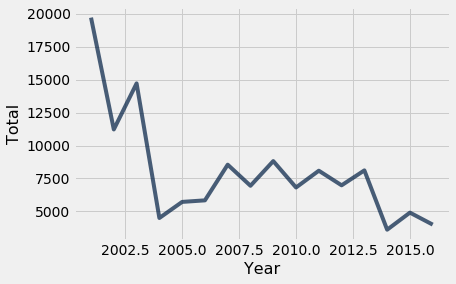

In [20]:
print("The number of the route with the lowest average monthly growth rate is {:f}".format(int(int(lowest_growth.item(0)))))
lowest_table.plot('Year', 'Total')

The number of the route with the highest average monthly growth rate is 172.000000


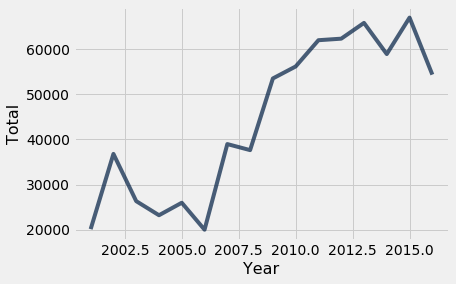

In [21]:
print("The number of the route with the highest average monthly growth rate is {:f}".format(int(int(highest_growth.item(0)))))
highest_table.plot('Year', 'Total')

## The University of Chicago

**The Question:** Is there a statistically significant difference in average ridership for routes with the University of Chicago as a terminus during the summer versus during the school year?

> **Null Hypothesis:** At the 5% significance level, the difference in CTA ridership in lines with the University of Chicago as a terminus during the summer versus during the school year is not statistically significant.


> **Alternative Hypothesis:** At the 5% significance level, there is a statistically significant decrease in CTA ridership in lines with the University of Chicago as a terminus during the summer versus during the school year.


**Setting up the Data:** For this question, I examine only the lines that lead to the University of Chicago. For the purposes of this project, I assume that only the lines whose names include the phrase 'U. of Chicago' lead to the University.

Typically the University of Chicago's "summer quarter" begins mid-June and lasts until roughly the end of September. Thus, for the purposes of this project, I will be counting the months of June, July, August, and September as "summer months" and the other eight months as the "school year."

In [22]:
# First, I create an empty array called uchicago. Then, I use a for loop to iterate through
# the array of line names to find those which contain the phrase 'U. of Chicago' and append the matching lines
# to the empty array if they are not already in the array.
# Finally, I use this array of names of lines that lead to the University to truncate the cta table
# to show only these lines. This new table will be called uchicago_table.

#Once again the data on averages isn't quite relevant so I drop these columns.

names = cta.column('Name')
uchicago = make_array()
for i in names:
    if 'U. of Chicago' in i and i not in uchicago:
        uchicago = np.append(uchicago, i)
uchicago_table = cta.where('Name', are.contained_in(uchicago)).drop(3, 4, 5)
uchicago_table

/srv/app/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


Route,Name,Month,Total
170,U. of Chicago/Midway,01/01/2001,6315
171,U. of Chicago/Hyde Park,01/01/2001,21573
172,U. of Chicago/Kenwood,01/01/2001,20116
173,U. of Chicago/Lakeview Express,01/01/2001,9088
170,U. of Chicago/Midway,02/01/2001,5758
171,U. of Chicago/Hyde Park,02/01/2001,20728
172,U. of Chicago/Kenwood,02/01/2001,19198
173,U. of Chicago/Lakeview Express,02/01/2001,7703
170,U. of Chicago/Midway,03/01/2001,5233
171,U. of Chicago/Hyde Park,03/01/2001,23436


Since there are, obviously, fewer summer months than months during the school year, it's easiest to create an array containing summer months and use this to make two separate tables with summer months and school year months than it is to do so by creating an array containing school year months.

Below I use a for loop to iterate through the 'Month' column and create an array of summer months.

In [23]:
summer_data = make_array()

for month in uchicago_table.column(2):
    if '06/01' in month or '07/01' in month or '08/01' in month or '09/01' in month:
        summer_data = np.append(summer_data, month)

Below is the table containing data for summer months (the months contained in `summer_data`).

In [24]:
uchicago_summer = uchicago_table.where('Month', are.contained_in(summer_data))
uchicago_summer

Route,Name,Month,Total
170,U. of Chicago/Midway,06/01/2001,4318
171,U. of Chicago/Hyde Park,06/01/2001,10290
172,U. of Chicago/Kenwood,06/01/2001,8920
173,U. of Chicago/Lakeview Express,06/01/2001,1575
170,U. of Chicago/Midway,07/01/2001,3335
171,U. of Chicago/Hyde Park,07/01/2001,5412
172,U. of Chicago/Kenwood,07/01/2001,6268
170,U. of Chicago/Midway,08/01/2001,4494
171,U. of Chicago/Hyde Park,08/01/2001,4473
172,U. of Chicago/Kenwood,08/01/2001,5486


And here is the table containing data for the school year (the months *not* contained in `summer_data`).

In [25]:
uchicago_schoolyear = uchicago_table.where('Month', are.not_contained_in(summer_data))
uchicago_schoolyear

Route,Name,Month,Total
170,U. of Chicago/Midway,01/01/2001,6315
171,U. of Chicago/Hyde Park,01/01/2001,21573
172,U. of Chicago/Kenwood,01/01/2001,20116
173,U. of Chicago/Lakeview Express,01/01/2001,9088
170,U. of Chicago/Midway,02/01/2001,5758
171,U. of Chicago/Hyde Park,02/01/2001,20728
172,U. of Chicago/Kenwood,02/01/2001,19198
173,U. of Chicago/Lakeview Express,02/01/2001,7703
170,U. of Chicago/Midway,03/01/2001,5233
171,U. of Chicago/Hyde Park,03/01/2001,23436


We define a function called `sample_100` which will take an array and a number of repetitions as arguments. The function will run a for loop the number of times specified by the repetitions argument.

The for loop will do the following:

1. Draw (with replacement) 100 samples from the array.
2. Take the mean of the 100 samples.
3. Append each of the means to an empty array.

The function `sample_100` will return an array of means.

In [26]:
def sample_100(array, repetitions):
    result = make_array()
    for i in np.arange(repetitions):
        random = np.random.choice(array, 100)
        mean = np.mean(random)
        result = np.append(result, mean)
    return result

Below I run the function `sample_100` on the 'Total' column of `uchicago_summer`. I create a table from the resulting array and then create a histogram of it.

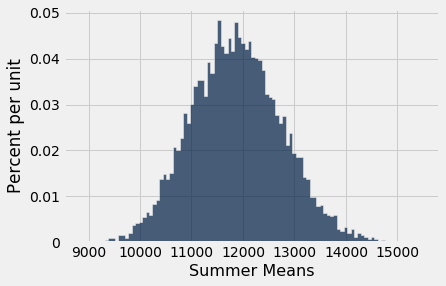

In [27]:
summer_sample = sample_100(uchicago_summer.column(3), 10000)
summer_table = Table().with_column('Summer Means', summer_sample)
summer_table.hist(0, bins=100)

Below I run the function `sample_100` on the 'Total' column of `uchicago_summer`. I create a table from the resulting array and then create a histogram of it.

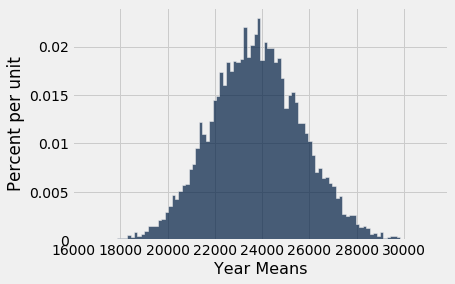

In [28]:
year_sample = sample_100(uchicago_schoolyear.column(3), 10000)
year_table = Table().with_column('Year Means', year_sample)
year_table.hist(0, bins=100)

Below I use the `percentile` function to generate 95% confidence intervals of the data used in the two histograms. If there is no overlap between the two 95% confidence intervals, then there is statistically significant evidence that can lead to rejecting the null hypothesis in favour of the alternative hypothesis at the 5% significance level. If not, we cannot reject the null hypothesis at the 5% significance level.

In [29]:
summer_left = percentile(2.5, summer_table.column(0))
summer_right = percentile(97.5, summer_table.column(0))
year_left = percentile(2.5, year_table.column(0))
year_right = percentile(97.5, year_table.column(0))

print("95% Confidence Interval for mean number of rides during the summer: [{:f}, {:f}]".format(summer_left, summer_right))
print("95% Confidence Interval for mean number of rides during the school year: [{:f}, {:f}]".format(year_left, year_right))

95% Confidence Interval for mean number of rides during the summer: [10207.980000, 13662.040000]
95% Confidence Interval for mean number of rides during the school year: [20053.670000, 27636.160000]


>**Conclusion:** The upper bound of the 95% confidence interval for average summer ridership is 13645.47 which is quite a bit lower than 20125.83, which is the lower bound of the 95% confidence interval for average school year ridership.

>**Thus, at the 5% significance level, there is significant statistical evidence to lead to rejecting the null hypothesis that ridership on lines with the University of Chicago as a terminus during the summer months is, on average, equal to what it is during months of the school year.**

## Ventra

**The Question:** In August 2013, the CTA launched its partnership with Ventra, an electronic fare payment system. Ventra was meant to replace all other existing methods of payment by July 2014.

What kind of impact, if any, has launching Ventra had on CTA bus ridership?

Is there a statistically significant difference in ridership before Ventra’s launch, during the transition period (8/13 to 7/14), and after it became the sole payment system for the CTA?

> **Null Hypothesis:** At the 5% significance level, the difference in means in CTA ridership before the launch of Ventra, during the transition period, and after it became the sole payment system for the CTA is not statistically significant.
> In other words, $μ_{1}$ = $μ_{2}$ = $μ_{3}$.


> **Alternative Hypothesis:** At the 5% significance level, there is a statistically significant difference in the means in CTA ridership before the launch of Ventra, during the transition period, and after it became the sole payment system for the CTA.
> In other words, one or more of $μ_{1}$,  $μ_{2}$ and $μ_{3}$ are not equal to the others.

**Statistical Methods**: Because I am comparing three different population means, I will use the one-way ANOVA (analysis of variance) method.

**Setting up the Data:** For this question, I will break the data in `balanced_table` up into three separate tables. The first will contain the data for the pre-Ventra period, one will contain the data for months during the transition period, and one will contain post-Ventra data. Anything prior to September 2013 is "pre-Ventra" and anything starting July 2014 is post-Ventra.

In order to break up the data I will do the following:
1. Create an array called `months` from `cta` using the group method and the column method.
2. Using this array and list comprehensions, create three different lists of months corresponding to each of the three different periods.
3. Finally, using these lists and the where method with the `are.contained_in` predicate, I break balanced table up into three smaller tables called `pre_table`, `post_table`, and `transition_table`

In [30]:
post = [i for i in months if '2017' in i or '2016' in i or '2015' in i] + ['07/01/2014','08/01/2014','09/01/2014','10/01/2014','11/01/2014','12/01/2014']
pre = [i for i in months if '2001' in i or '2002' in i or '2003' in i or '2004' in i or '2005' in i or '2006' in i or '2007' in i  or '2008' in i  or '2009' in i  or '2010' in i  or '2011' in i or '2012' in i] + ['01/01/2013','02/01/2013','03/01/2013','04/01/2013','05/01/2013','06/01/2013','07/01/2013','08/01/2013']
transition = [i for i in months if i not in post and i not in pre]

In [31]:
pre_table = balanced_table.where('Month', are.contained_in(pre))
post_table = balanced_table.where('Month', are.contained_in(post))
transition_table = balanced_table.where('Month', are.contained_in(transition))
pre_table

Route,Name,Month,Total
2,Hyde Park Express,01/01/2001,22001
3,King Drive,01/01/2001,567413
4,Cottage Grove,01/01/2001,618796
6,Jackson Park Express,01/01/2001,493926
7,Harrison,01/01/2001,121097
8,Halsted,01/01/2001,521892
8A,South Halsted,01/01/2001,89030
9,Ashland,01/01/2001,811006
12,Roosevelt,01/01/2001,288055
18,16th/18th,01/01/2001,49130


Below I run the function `sample_100` on the 'Total' column of all three tables using 1000 repetitions. I create a table from the resulting arrays and then create histograms of each column to serve as visualization aids.

In [32]:
pre_sample = sample_100(pre_table.column(3), 10000)
pre = Table().with_column('Pre-Ventra Means', pre_sample)

transition_sample = sample_100(transition_table.column(3), 10000)
transition = Table().with_column('Transition Means', transition_sample)

post_sample = sample_100(post_table.column(3), 10000)
post = Table().with_column('Post-Ventra Means', post_sample)

ventra_means = Table().with_columns('Pre Means', pre_sample, 'Transition Means', transition_sample, 'Post Means', post_sample)
ventra_means

Pre Means,Transition Means,Post Means
207597,194774,191038
216271,261396,198440
249716,217351,198013
225352,226810,221653
201479,277839,231405
232070,181499,216943
223593,207444,194014
211133,221090,166971
241359,224433,213318
223427,213839,215351


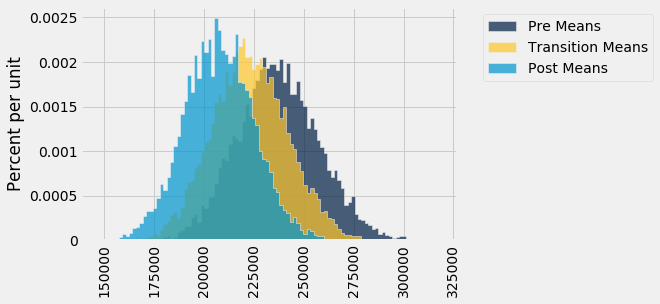

In [33]:
ventra_means.hist(0, 1, 2, bins=100)

In order to conduct a one-way ANOVA test, we need to know the means of `pre_sample`, `transition_sample`, and `post_sample` as well as a "grand mean" which is the mean of all of the data in all of these arrays.

The steps to conducting a one-way ANOVA test are as follows:
1. Find the ridership means of each of the periods being compared.
2. Using these means, find the variance in the data for each of the periods and sum these variances.
3. Find a "grand mean" which is the mean of all of the data in all of the arrays.
4. Compute the variance between each of the individual means using the "grand mean"
5. Divide the "grand mean" variance by the sum of variances for each period.
6. Compare this value to the critical value found in the F-critical values table.

Because there are 3 samples (m) and the total size of all of the samples together is 3000 (n), the degrees of freedom are as follows:

The numerator has m-1 = **2 degrees of freedom**.

The denominator has n-m = **2997 degrees of freedom**.

Based on the F-Table for the chosen α value of 0.05 and the found degrees of freedom, the critical F-value to which I must compare the F-score that I will be calculating is **3.00**.

If the calculated F-score is greater than 3.00, then I will reject the null hypothesis.

Here are the means of `pre_sample`, `transition_sample`, and `post_sample` and the "grand mean":

In [34]:
pre_mean = np.mean(pre_sample)
transition_mean = np.mean(transition_sample)
post_mean = np.mean(post_sample)
means = make_array(pre_mean, transition_mean, post_mean)
grand_mean = np.mean(means)
print("Pre-Ventra Ridership Mean: {:f}".format(pre_mean))
print("Transition Period Ridership Mean: {:f}".format(transition_mean))
print("Post-Ventra Ridership Mean: {:f}".format(post_mean))
print("Grand Mean: {:f}".format(grand_mean))

Pre-Ventra Ridership Mean: 236899.265917
Transition Period Ridership Mean: 222683.655720
Post-Ventra Ridership Mean: 207285.942826
Grand Mean: 222289.621488


Below I define a function `diff_mean_sq` that will help calculate the denominator variance.

The function takes in an array as an argument and does the following:
1. Takes the mean of the array.
2. Creates an empty array called `a`.
3. For each item in the original array, find the difference between that item and the mean of the array and then square this difference.
4. Append each of these squared differences to empty array `a`.
5. Return the sum of all items in `a`.


In [35]:
def diff_mean_sq(array):
    mean = np.mean(array)
    a = make_array()
    for i in array:
        diff_sq = (i - mean)**2
        a = np.append(a, diff_sq)
    return sum(a)

And here are the variance that will be used in the numerator and denomator as well as the F-score that comes from dividing the numerator by the denominator:

In [36]:
var_num = (1000*((pre_mean-grand_mean)**2+(transition_mean-grand_mean)**2+(post_mean-transition_mean)**2))/(3-1)
var_den = (diff_mean_sq(pre_sample) + diff_mean_sq(transition_sample) + diff_mean_sq(post_sample)) / (3000-3)
f_score = var_num / var_den
print("Numerator: {:f}".format(var_num))
print("Denominator: {:f}".format(var_den))
print("F-Score: {:f}".format(f_score))

Numerator: 225343267846.927399
Denominator: 3596797243.703134
F-Score: 62.651090


Clearly the calculated F-score of 63.05 is significantly larger than the critical F-value. Thus I conclude the following:

>**Conclusion:** At the 5% significance level, we can reject the null hypothesis that the mean ridership before the introduction of Ventra was the same as that during the transition period to Ventra and as that during the period during which Ventra became the sole payment method used by the CTA. There is statistical significant evidence to support the alternative hypothesis that one or more of these means are significantly different from the others.